In [29]:
%matplotlib notebook

In [30]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pandas import DataFrame
import json
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
from datetime import datetime

In [88]:
#load mask mandates.
us_state_mask_mandtes_df = pd.read_csv('US_State_Mask_Mandates.csv')

# This data set has State_Tribe_Territory as filed name so renamed the State_Tribe_Territory field name to state
us_state_mask_mandtes_df.rename(columns={'State_Tribe_Territory':'state'},inplace=True)

#converting date field into datetime64 data type because this field will be used to join two datasets
us_state_mask_mandtes_df['date'] = us_state_mask_mandtes_df['date'].astype('datetime64[ns]')

//print the data frame
us_state_mask_mandtes_df



,state,date,order_code,Face_Masks_Required_in_Public,Specific_counties,Source_of_Action,URL,Citation
0,AK,2020-04-08,1,NaN,NaN,NaN,NaN,NaN
1,AK,2020-04-09,1,NaN,NaN,NaN,NaN,NaN
2,AK,2020-04-10,1,NaN,NaN,NaN,NaN,NaN
3,AK,2020-04-11,1,NaN,NaN,NaN,NaN,NaN
4,AK,2020-04-12,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
27715,WY,2021-08-11,1,No,NaN,Official,https://health.wyo.gov/updated-statewide-publi...,"Wyo. Press Release (Mar. 12, 2021)"
27716,WY,2021-08-12,1,No,NaN,Official,https://health.wyo.gov/updated-statewide-publi...,"Wyo. Press Release (Mar. 12, 2021)"
27717,WY,2021-08-13,1,No,NaN,Official,https://health.wyo.gov/updated-statewide-publi...,"Wyo. Press Release (Mar. 12, 2021)"
27718,WY,2021-08-14,1,No,NaN,Official,https://health.wyo.gov/updated-statewide-publi...,"Wyo. Press Release (Mar. 12, 2021)"


In [90]:
#filter only the records that has face mask required in public
us_state_mask_mandtes_small_df = us_state_mask_mandtes_df[['state','Face_Masks_Required_in_Public']]

#drop records that does not have face masks required in public data
us_state_mask_mandtes_small_df.dropna(subset=['Face_Masks_Required_in_Public'],inplace=True)

#keep only records that has face mask required Yes
public_area_face_mask_states_df = us_state_mask_mandtes_small_df.loc[us_state_mask_mandtes_small_df['Face_Masks_Required_in_Public'].isin(['Yes'])]

#remove duplicate recoreds
public_area_mask_mandate_group_df = public_area_face_mask_states_df.drop_duplicates(subset=['state','Face_Masks_Required_in_Public'])


public_area_mask_mandate_group_df.count()

state                            44
Face_Masks_Required_in_Public    44
dtype: int64

In [91]:
# Load united states covid-19 cases and deaths by steate ove rtime dataset
usa_confimed_cases_df = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')


# Rename submission_date as date
usa_confimed_cases_df.rename(columns={'submission_date':'date'},inplace=True)

#explcity convert object type to datetime data type
usa_confimed_cases_df['date'] = usa_confimed_cases_df['date'].astype('datetime64[ns]')

usa_confimed_cases_df.head()



,date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,2021-12-01,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree
1,2021-09-01,ND,118491,107475.0,11016.0,536,66.0,1562,NaN,NaN,1,0.0,09/02/2021 01:49:05 PM,Agree,Not agree
2,2021-08-08,MD,473969,NaN,NaN,853,0.0,9881,9660.0,221.0,6,1.0,08/10/2021 12:00:00 AM,NaN,Agree
3,2020-05-13,VT,855,NaN,NaN,2,0.0,52,NaN,NaN,0,0.0,05/15/2020 12:00:00 AM,Not agree,Not agree
4,2021-02-02,IL,1130917,1130917.0,0.0,2304,0.0,21336,19306.0,2030.0,63,16.0,02/03/2021 02:55:58 PM,Agree,Agree


In [92]:
#Combine two datasets
combined_dataset = pd.merge(us_state_mask_mandtes_df,usa_confimed_cases_df,how='left',on=['state','date'])

#reduce numbers fields
small_dataset = combined_dataset[{'state','tot_cases','order_code'}]

group_total_cases_df = small_dataset.groupby('state').sum().reset_index()

group_total_cases_df.head()

,state,tot_cases,order_code
0,AK,16890163,495
1,AL,149424837,1029
2,AR,93691285,1003
3,AS,452,531
4,AZ,237149485,495


In [93]:
#add face required in public info
group_total_cases_df = pd.merge(group_total_cases_df,public_area_mask_mandate_group_df,how='left',on=['state'])

group_total_cases_df.fillna(0, inplace=True)

group_total_cases_df['Face_Masks_Required_in_Public'] = group_total_cases_df['Face_Masks_Required_in_Public'].replace(['Yes'],250)

group_total_cases_df['Face_Masks_Required_in_Public'] = group_total_cases_df['Face_Masks_Required_in_Public'].replace(['No'],0)


group_total_cases_df.head(55)

,state,tot_cases,order_code,Face_Masks_Required_in_Public
0,AK,16890163,495,0
1,AL,149424837,1029,250
2,AR,93691285,1003,250
3,AS,452,531,250
4,AZ,237149485,495,0
5,CA,978490679,1343,250
6,CO,136452709,1017,250
7,CT,87939079,1461,250
8,DC,13757346,1267,250
9,DE,27439137,1317,250


Text(0, 0.5, 'Fask Mask Required (Yes/No)')

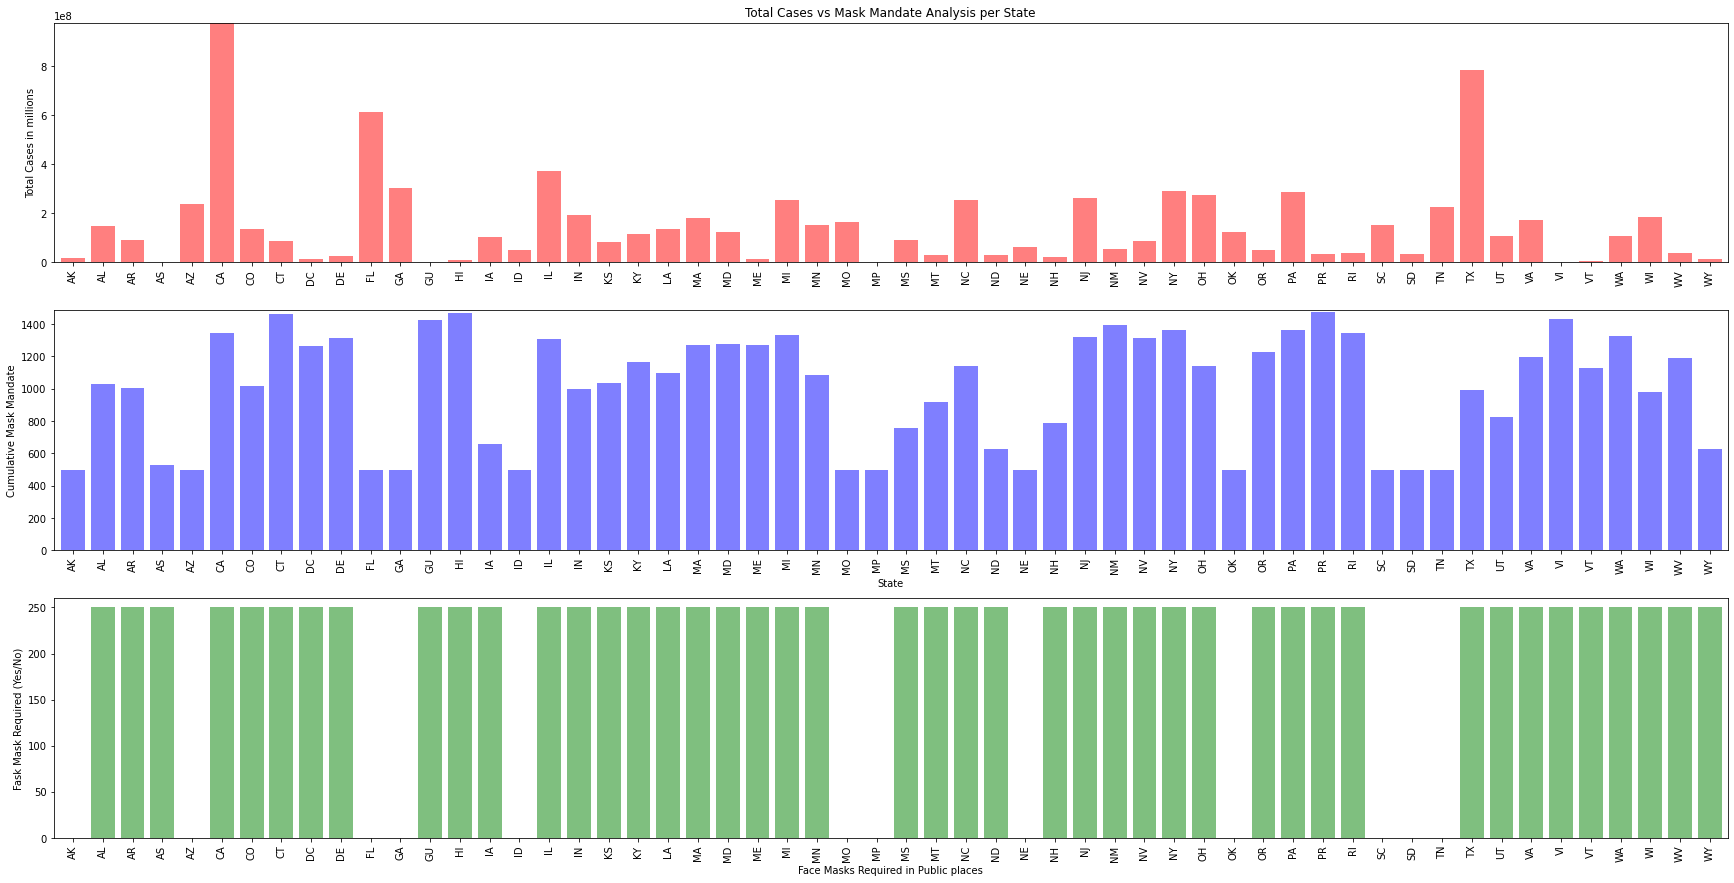

In [95]:
x_axis = np.arange(len(group_total_cases_df ))

tick_locations = [value+0.4 for value in x_axis]

fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(30,15))


ax1.bar(x_axis, group_total_cases_df["tot_cases"], color='r', alpha=0.5, align="edge")

ax1.set_xticks(tick_locations, group_total_cases_df["state"], rotation="vertical")

# Set x and y limits
ax1.set_xlim(-0.25, len(x_axis))
ax1.set_ylim(0, max(group_total_cases_df["tot_cases"])+10)

# Set a Title and labels
ax1.set_title("Total Cases vs Mask Mandate Analysis per State")
ax1.set_ylabel("Total Cases in millions")



ax2.bar(x_axis, group_total_cases_df["order_code"], color='b', alpha=0.5, align="edge")

ax2.set_xticks(tick_locations, group_total_cases_df["state"], rotation="vertical")

# Set x and y limits
ax2.set_xlim(-0.25, len(x_axis))
ax2.set_ylim(0, max(group_total_cases_df["order_code"])+10)

# Set a Title and labels

ax2.set_xlabel("State")
ax2.set_ylabel("Cumulative Mask Mandate")

#---------------------------

ax3.bar(x_axis, group_total_cases_df["Face_Masks_Required_in_Public"], color='g', alpha=0.5, align="edge")

ax3.set_xticks(tick_locations, group_total_cases_df["state"], rotation="vertical")

# Set x and y limits
ax3.set_xlim(-0.25, len(x_axis))
ax3.set_ylim(0, max(group_total_cases_df["Face_Masks_Required_in_Public"])+10)

# Set a Title and labels

ax3.set_xlabel("Face Masks Required in Public places")
ax3.set_ylabel("Fask Mask Required (Yes/No)")

<AxesSubplot:xlabel='Cumulative Mask Mandate includes Sum of mask order code plus Mask required in public ', ylabel='Cumulative Mask Mandate'>

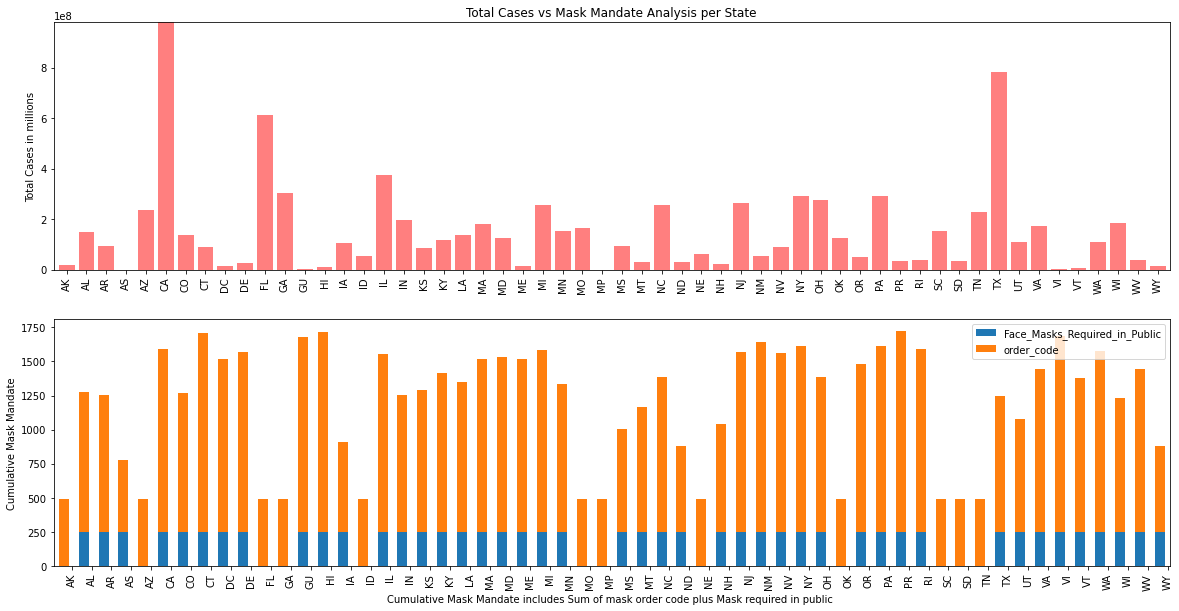

In [87]:
x_axis = np.arange(len(group_total_cases_df ))

tick_locations = [value+0.4 for value in x_axis]

fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))


ax1.bar(x_axis, group_total_cases_df["tot_cases"], color='r', alpha=0.5, align="edge")

ax1.set_xticks(tick_locations, group_total_cases_df["state"], rotation="vertical")

# Set x and y limits
ax1.set_xlim(-0.25, len(x_axis))
ax1.set_ylim(0, max(group_total_cases_df["tot_cases"]))

# Set a Title and labels
ax1.set_title("Total Cases vs Mask Mandate Analysis per State")
ax1.set_ylabel("Total Cases in millions")


mask_mandate_df = group_total_cases_df[{'state','order_code','Face_Masks_Required_in_Public'}]

ax2.set_xticks(tick_locations, group_total_cases_df["state"], rotation="vertical")

# Set x and y limits
ax2.set_xlim(-0.25, len(x_axis))
#ax2.set_ylim(0, max(group_total_cases_df["order_code"])+10)

# Set a Title and labels
#ax2.set_title("Total Cases vs Mask Mandate Analysis per State")
ax2.set_ylabel("Cumulative Mask Mandate")
ax2.set_xlabel("Cumulative Mask Mandate includes Sum of mask order code plus Mask required in public ")

mask_mandate_df.plot(ax = ax2,  kind='bar', stacked=True, xticks=tick_locations)




In [35]:
small_dataset = combined_dataset[{'state','order_code'}]

total_cases_count = combined_dataset['order_code'].value_counts()

# Display the info
#combined_dataset.info()

# Display the data table for preview
small_dataset.count()

small_dataset.head()

group_order_df = small_dataset.groupby('state').sum().reset_index()
group_order_df.head(100)

,state,order_code
0,AK,495
1,AL,1029
2,AR,1003
3,AS,531
4,AZ,495
5,CA,1343
6,CO,1017
7,CT,1461
8,DC,1267
9,DE,1317


KeyError: 'order_code'

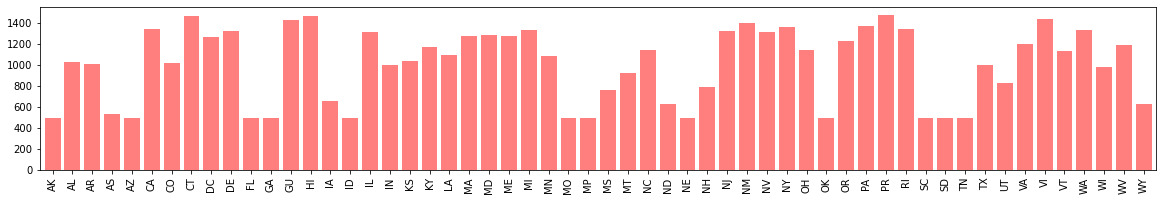

In [140]:
x_axis = np.arange(len(group_order_df ))

tick_locations = [value+0.4 for value in x_axis]

plt.figure(figsize=(20,3))

plt.bar(x_axis, group_order_df["order_code"], color='r', alpha=0.5, align="edge")

plt.xticks(tick_locations, group_df["state"], rotation="vertical")

# Set x and y limits
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, max(group_df["order_code"])+10)

# Set a Title and labels
plt.title("Total Cases per State")
plt.xlabel("State")
plt.ylabel("Total Cases in each state")

# Save our graph and show the grap
plt.tight_layout()
plt.savefig("../orders_by_state.png")

plt.show()



ax = df1.plot()

df2.plot(ax=ax)


In [ ]:
# This is my final dataset after dropping bad records with NaN values
combined_df_final = combined_dataset.dropna()
combined_df_final.head(20)

In [ ]:
combined_df_final.count()

In [ ]:
# Framinf the date range
A = '2020-01-01'
B = '2021-12-31'
#data_truncated = combined_df_final.loc[(combined_df_final['date'] >= A) & (combined_df_final['date'] <= B)]
#data_truncated.head(20)
#data_truncated.count()



In [ ]:
#What is the count of variants in different locations ?
#group_data = data_truncated.groupby('facial_coverings')
#group_data.head()
#group_data.count()

In [ ]:
canada_df = data_truncated.loc[data_truncated['country'].isin(['Canada'])]
canada_df_grouped = canada_df.groupby(['date','facial_coverings'])
x_axis = canada_df[['facial_coverings']]
dates = canada_df[['date']]
plt.xticks(rotation=90)
plt.plot(dates,x_axis,linewidth=2, markersize=10,marker="p",color="orange")

#US data plot
us_df = data_truncated.loc[data_truncated['country'].isin(['United States'])]
us_df_grouped = us_df.groupby(['date','facial_coverings'])
x_axis = us_df['facial_coverings']
dates = us_df['date']

plt.plot(dates,x_axis,linewidth=2, markersize=10,marker="p",color="blue")

#Germany data plot
germany_df = data_truncated.loc[data_truncated['country'].isin(['Germany'])]
germany_df_grouped = germany_df.groupby(['date','facial_coverings'])
x_axis = germany_df['facial_coverings']
dates = germany_df['date']

plt.plot(dates,x_axis,linewidth=2, markersize=10,marker="p",color="green")

plt.tight_layout()
plt.show()

In [ ]:

usa_df = data_truncated.loc[data_truncated['country'].isin(['United States'])]
#usa_df['daily_cases'] =usa_df['ConfirmedCases'].diff()
#usa_df['daily_cases'] =usa_df['daily_cases'].fillna(0)

x1_usa = usa_df[['facial_coverings']]
x2_usa = usa_df[['variant']]
dates_usa = usa_df[['date']]

fig, ax = plt.subplots(figsize=(100, 30))
ax.plot(dates_usa,x1_usa,linewidth=7,color="r",label='Mask Mandates')
ax.tick_params('y',colors='r',labelsize=40)
ax.tick_params('x',color='k',labelsize=40)
ax.set_title('UNITED STATES',fontsize = 100)
ax.set_xlabel('Dates', fontsize=60)
ax.xaxis.set_label_coords(.5, -.06)
ax.set_ylabel('Mandate Leves', fontsize=60)
ax.yaxis.set_label_coords(-0.02, .5)
ax.set_facecolor('xkcd:white')
ax.set_ylim(top = 4.1)
ax2 =ax.twinx()
ax2.plot(dates_usa,x1_usa,linewidth=4,color="b",label='Daily Confirmed Cases')

#lt.savefig("United States.png")


In [ ]:




ax2.set_ylabel('Confirmed Cases', fontsize=60)
ax2.yaxis.set_label_coords(1.04, .5)
ax2.tick_params('y', colors='b',labelsize=40)
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best',fontsize=60)
ax2.grid(True)